In [184]:
import pandas as pd
import numpy as np
import string as s
import seaborn as sns
import random
import math
import tables
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style, colors
from itertools import groupby
import matplotlib.patches as patches
from matplotlib import gridspec
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata, leaves_list
from scipy.spatial.distance import pdist
from scipy.ndimage.interpolation import shift
# matplotlib.style.use('ggplot')
# %matplotlib inline
matplotlib.rcParams['figure.figsize'] = (32, 6)
# matplotlib.rcParams['figure.facecolor'] = 'white'
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.samples_generator import make_swiss_roll
matplotlib.style.use('ggplot')
%matplotlib inline

Here is how we will include variants:
All high/moderate/low impact variants, 
the two TERT promoter mutations, and 
a random subset of non-coding variants. The number of non-coding variants should be distributed somewhat evenly across all chromosomes
The maximum number of variants submitted to Expands should remain ~8000.

these are the 2 TERT promoter mutations that should be included as expandas input.
MUT_5.GRCh37:g.1295250G>A	MUT	5.GRCh37	g.1295250G>A	5.GRCh37:g.1295250G>A	TERT:c.-146C>T
MUT_5.GRCh37:g.1295228G>A	MUT	5.GRCh37	g.1295228G>A	5.GRCh37:g.1295228G>A	TERT:c.-124C>T

vcf files used for expands anaylsis are here:
/projects/mwarren_prj/mwarren_prj_results/VDB-241/pog500_annotated_all_biopsies.vcf
/projects/mwarren_prj/mwarren_prj_results/VDB-241/pog500_modifer_all_biopsies.vcf

copy number results (ploidy and tumour content corrected) generated by Eric are here:
https://www.bcgsc.ca/jira/browse/SDEV-133
/projects/ezhao_prj/analyses/mutation-signature-pipeline/data/pog/genome/cohorts/*/cnv_segs/*

In [27]:
def unique(a):
    """ return the list with duplicate elements removed """
    return list(set(a))

def intersect(a, b):
    """ return the intersection of two lists """
    return list(set(a) & set(b))

def union(a, b):
    """ return the union of two lists """
    return list(set(a) | set(b))

def exclusive(a, b):
    """ return items either exclusive in a or b """
    return list(set(a) ^ set(b))

def unique2a(a, b):
    """ return items only in a, but not in b """
    return list(set(a) & set(set(a) ^ set(b)))

def write(lst, of):
    with open(of, "w") as output:
        writer = csv.writer(output, lineterminator='\n')
        for val in lst:
            writer.writerow([val]) 

In [3]:
f = '/projects/trans_scratch/validations/workspace/szong/EXPANDS_500/pog500_annotated_all_biopsies.vcf'
df = pd.read_csv(f, sep='\t')

/home/szong/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.head(2)

,#chrom,pos,id,ref,alt,qual,filter,info,af_tumour,tumour_ref_count,tumour_alt_count,tumour_total_count,library_name,pog_id,gene_id,transcript_id,aa_change,effect,impact,cancer_stage
0,1,874459,.,T,A,31;0.858,.,.,0.283951,58,23,81,P01309,POG457,SAMD11,ENST00000342066,p.Ile157Asn/c.470T>A,missense_variant,MODERATE,Metastatic
1,1,878237,.,C,T,70;1,.,.,0.581818,23,32,55,P02559,POG929,SAMD11,ENST00000342066,p.Leu455Phe/c.1363C>T,missense_variant,MODERATE,Metastatic


In [ ]:
# df.groupby(['pog_id', 'library_name'])[[]]

In [5]:
df.library_name.nunique()

633

In [6]:
lib1 = df.library_name.unique()

In [7]:
# number of pogs
df.pog_id.nunique()

568

In [8]:

df_hml = pd.DataFrame(df.library_name.value_counts())
# df.library_name.value_counts().head()

/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 519 ms, sys: 6 ms, total: 525 ms
Wall time: 876 ms


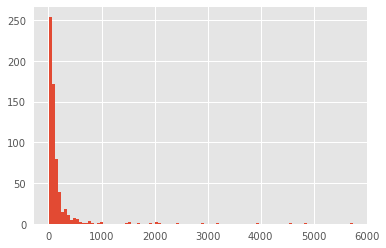

In [9]:
df.library_name.value_counts().hist(bins=100)

of = '/projects/trans_scratch/validations/workspace/szong/EXPANDS_500/number_strelka_mutations_distribution.png'
%time plt.savefig(of, bbox_inches='tight',dpi=200)

In [14]:
# minmum coverage 
df.tumour_total_count.sort_values().head(50)
df.loc[df.tumour_total_count.sort_values().head(12).index,:]

,#chrom,pos,id,ref,alt,qual,filter,info,af_tumour,tumour_ref_count,tumour_alt_count,tumour_total_count,library_name,pog_id,gene_id,transcript_id,aa_change,effect,impact,cancer_stage
43006,17,4795517,.,C,A,70;0.87,.,.,0.857143,1,6,7,T00391,POG054,MINK1,ENST00000355280,p.Ala692Glu/c.2075C>A,missense_variant,MODERATE,Primary
242,1,2431076,.,C,G,29;0.89,.,.,0.375000,5,3,8,T00369,POG027,PLCH2,ENST00000378486,\N,splice_region_variant+intron_variant,LOW,Primary
44433,17,18052095,.,G,A,46;0.85,.,.,0.500000,4,4,8,P00154,POG074,MYO15A,ENST00000205890,p.Arg2262His/c.6785G>A,missense_variant,MODERATE,Primary
73514,22,50636948,.,G,C,39;0.9,.,.,0.500000,4,4,8,P00154,POG074,TRABD,ENST00000303434,p.Ter377Tyrext*?/c.1131G>C,stop_lost,HIGH,Primary
72013,22,23488834,.,C,T,65;0.91,.,.,0.666667,3,6,9,T00344,POG044,RAB36,ENST00000263116,p.Pro77Ser/c.229C>T,missense_variant,MODERATE,Recurrent-Relapse
55862,19,43093754,.,C,T,17;0.85,.,.,0.333333,6,3,9,T00369,POG027,CEACAM8,ENST00000244336,p.Pro186Pro/c.558G>A,synonymous_variant,LOW,Primary
75338,3,47453090,.,G,T,52;0.95,.,.,0.666667,3,6,9,P00154,POG074,PTPN23,ENST00000265562,p.Gly1268Cys/c.3802G>T,missense_variant,MODERATE,Primary
34799,15,29346610,.,C,G,21;0.88,.,.,0.333333,6,3,9,T00369,POG027,APBA2,ENST00000558402,p.Leu175Val/c.523C>G,missense_variant,MODERATE,Primary
110511,9,139391901,.,G,A,44;0.87,.,.,0.444444,5,4,9,T00389,POG052,NOTCH1,ENST00000277541,p.Pro2097Leu/c.6290C>T,missense_variant,MODERATE,Primary
18044,11,55371698,.,C,T,22;0.85,.,.,0.333333,6,3,9,T00369,POG027,OR4C11,ENST00000302231,p.Arg51Gln/c.152G>A,missense_variant,MODERATE,Primary


In [186]:
f2 = '/projects/mwarren_prj/mwarren_prj_results/VDB-241/pog500_modifer_all_biopsies.vcf'
df2 = pd.read_csv(f2, sep='\t')
df2.head()

/home/szong/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,#chrom,pos,id,ref,alt,qual,filter,info,af_tumour,tumour_ref_count,tumour_alt_count,tumour_total_count,library_name,pog_id,cancer_stage
0,1,14248,.,T,G,20;0.87,.,.,0.213115,48,13,61,P01890,POG687,Metastatic
1,1,14653,.,C,T,20;0.86,.,.,0.233333,45,14,60,P01986,POG737,Metastatic
2,1,16682,.,G,A,34;0.87,.,.,0.170732,68,14,82,P02423,POG824,Metastatic
3,1,17534,.,G,C,39;0.98,.,.,0.298246,40,17,57,P00112,POG074,Metastatic
4,1,57033,.,T,C,52;0.897,.,.,0.179856,114,25,139,P01348,POG130,Metastatic


find TERT promoter mutations

In [187]:
df21 = (df2[df2['#chrom']==5])
df22 = df21[(df21['pos']==1295228) | (df21['pos']==1295250)]

In [188]:
df22

,#chrom,pos,id,ref,alt,qual,filter,info,af_tumour,tumour_ref_count,tumour_alt_count,tumour_total_count,library_name,pog_id,cancer_stage
6624913,5,1295228,.,G,A,18;0.91,.,.,0.442623,34,27,61,P00115,POG075,Recurrent-Relapse
6624914,5,1295228,.,G,A,62;0.868,.,.,0.333333,58,29,87,P01559,POG574,Metastatic
6624915,5,1295228,.,G,A,68;0.99,.,.,0.387097,57,36,93,P01884,POG581,Metastatic
6624916,5,1295228,.,G,A,30;0.99,.,.,0.254545,40,14,55,P01825,POG637,Metastatic
6624917,5,1295228,.,G,A,41;0.89,.,.,0.242424,75,24,99,P01890,POG687,Metastatic
6624918,5,1295228,.,G,A,54;0.99,.,.,0.357143,36,20,56,P01902,POG693,Metastatic
6624919,5,1295228,.,G,A,44;0.99,.,.,0.330189,71,35,106,P01935,POG694,Metastatic
6624920,5,1295228,.,G,A,67;1,.,.,0.439394,36,29,66,P01920,POG705,Metastatic
6624921,5,1295228,.,G,A,77;0.96,.,.,0.402062,58,39,97,P02122,POG777,Metastatic
6624922,5,1295228,.,G,A,25;0.93,.,.,0.172727,91,19,110,P02455,POG927,Metastatic


In [79]:
df23 = pd.DataFrame(df22.library_name.value_counts())

In [16]:
lib2 = df2.library_name.unique()

In [17]:
len(lib1)

633

In [18]:
len(lib2)

634

In [29]:
# number of pogs
pogids2 = df2.pog_id.unique()

In [20]:
pog_libs = pd.Series(np.concatenate((lib1, lib2))).unique()

In [105]:
f_pogtable = '/projects/trans_scratch/validations/workspace/szong/EXPANDS_500/POG500_analysis_groups_V3_from_Erin.xls'
df_pt = pd.read_excel(f_pogtable, sheetname='POG500_biop_details')
df_pt.head(2)

,ID,Biopsy #,Nonstandard,t_name,t_dna_lib,t_rna_lib,biopsy_date,n_name,n_dna_lib,a1_name,...,c_name,c_dna_lib,c_rna_lib,CANCER TYPE,HISTOLOG. TYPE,BIOPSY SITE,MET OR PRIMARY,ANALYSIS COHORT,PRIMARY SITE,Comment
0,POG001,1,NaN,biop1,A10504,A10506,2012-07-10,blood1,A10501,arch1,...,NaN,NaN,NaN,Colorectal Adenocarcinoma,COAD,Liver,Metastatic,COLO,Colon,NaN
1,POG002,1,NaN,biop1,A10512,A10513,2012-08-28,blood1,A10511,arch1,...,NaN,NaN,NaN,Breast Invasive Ductal Carcinoma,IDC,Liver,Metastatic,BRCA,Breast,NaN


In [106]:
df_pt.shape

(570, 28)

In [30]:
pogids_pt = df_pt.ID.unique()

In [31]:
unique2a(pogids_pt, pogids2)

['POG309']

In [32]:
df_mod = pd.DataFrame(df2.library_name.value_counts())
# df2.library_name.value_counts().tail()
# df2.library_name.value_counts().head()

/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 513 ms, sys: 10 ms, total: 523 ms
Wall time: 530 ms


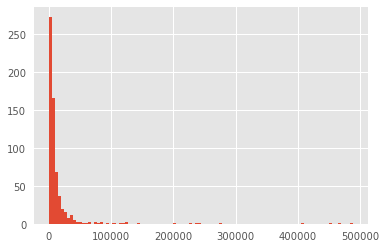

In [33]:
df2.library_name.value_counts().hist(bins=100)

of = '/projects/trans_scratch/validations/workspace/szong/EXPANDS_500/number_strelka_modifier_mutations_distribution.png'
%time plt.savefig(of, bbox_inches='tight',dpi=200)

In [89]:
dfm = pd.merge(df_hml, df_mod, left_index=True, right_index=True)
dfm.columns = ['hml_mut', 'mod_mut']

In [90]:
dfm['total'] = dfm.hml_mut + dfm.mod_mut


In [91]:
dfm = dfm.sort_values('total', ascending=False).reset_index()

In [92]:
# dfm = dfm[dfm.total < 8000]
df23.head(2)

,library_name
P02455,2
P02103,1


In [93]:
dfm.head(2)

,index,hml_mut,mod_mut,total
0,T00160,5739,488285,494024
1,P02455,4846,468380,473226


In [94]:
dfm = pd.merge(dfm, df23, left_on='index', right_index=True, how='left').fillna(0)

In [95]:
dfm.head(2)

,index,hml_mut,mod_mut,total,library_name
0,T00160,5739,488285,494024,0.0
1,P02455,4846,468380,473226,2.0


In [96]:
dfm['num_modifer_to_sample'] = 8000 - (dfm.hml_mut + dfm.library_name)

In [98]:
dfm = dfm.set_index('index').astype(int)

In [101]:
dfm['num_unsampled_modifers'] = dfm.mod_mut - dfm.num_modifer_to_sample

In [103]:
dfm.columns

Index(['hml_mut', 'mod_mut', 'total', 'library_name', 'num_modifer_to_sample',
       'num_unsampled_modifers'],
      dtype='object')

In [104]:
dfm.columns = ['hml_mut', 'mod_mut', 'total', 'num_TERT_promoter_mut', 'num_modifer_to_sample',
       'num_unsampled_modifers']

In [108]:
of = '/projects/trans_scratch/validations/workspace/szong/EXPANDS_500/libraries_snvs.txt'
# dfm.to_csv(of, sep='\t')

/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 15.4 s, sys: 6.46 s, total: 21.9 s
Wall time: 27.5 s


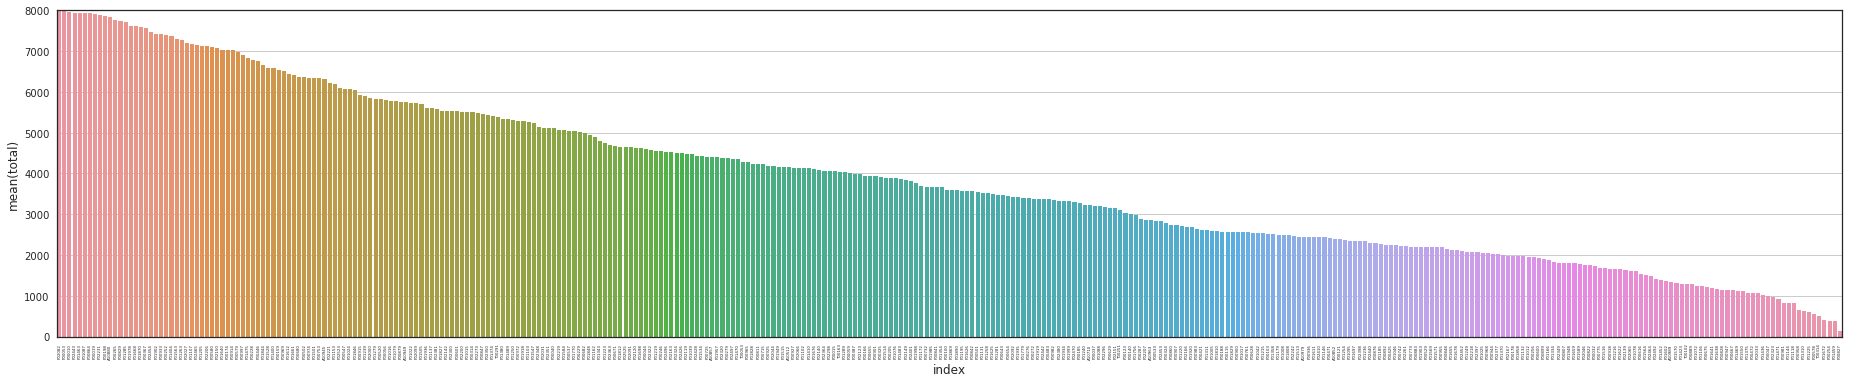

In [75]:
with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    fig = plt.figure(facecolor='w', figsize=(32, 6))
    sns.barplot('index', 'total', data = dfm)
    plt.ylim(0, 8000)
    plt.xticks(rotation=90, fontsize=4)
    
of = '/projects/trans_scratch/validations/workspace/szong/EXPANDS_500/number_strelka_mutations_less_than_8000.png'
%time plt.savefig(of, bbox_inches='tight',dpi=300)

determine number of variants to sample

In [149]:
f1 = '/projects/trans_scratch/validations/workspace/szong/EXPANDS_500/pog500_annotated_all_biopsies.vcf'
df1 = pd.read_csv(f, sep='\t')
df1.head(2)

/home/szong/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,#chrom,pos,id,ref,alt,qual,filter,info,af_tumour,tumour_ref_count,tumour_alt_count,tumour_total_count,library_name,pog_id,gene_id,transcript_id,aa_change,effect,impact,cancer_stage
0,1,874459,.,T,A,31;0.858,.,.,0.283951,58,23,81,P01309,POG457,SAMD11,ENST00000342066,p.Ile157Asn/c.470T>A,missense_variant,MODERATE,Metastatic
1,1,878237,.,C,T,70;1,.,.,0.581818,23,32,55,P02559,POG929,SAMD11,ENST00000342066,p.Leu455Phe/c.1363C>T,missense_variant,MODERATE,Metastatic


In [150]:
df1.shape

(114746, 20)

In [151]:
of = '/projects/trans_scratch/validations/workspace/szong/EXPANDS_500/libraries_snvs.txt'
df51 = pd.read_csv(of, sep='\t')
df51.head(2)

,index,hml_mut,mod_mut,total,num_TERT_promoter_mut,num_modifer_to_sample,num_unsampled_modifers
0,T00160,5739,488285,494024,0,2261,486024
1,P02455,4846,468380,473226,2,3152,465228


In [152]:
df51.shape

(633, 7)

In [178]:
f2 = '/projects/mwarren_prj/mwarren_prj_results/VDB-241/pog500_modifer_all_biopsies.vcf'
df2 = pd.read_csv(f2, sep='\t')
df2.head()

/home/szong/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,#chrom,pos,id,ref,alt,qual,filter,info,af_tumour,tumour_ref_count,tumour_alt_count,tumour_total_count,library_name,pog_id,cancer_stage
0,1,14248,.,T,G,20;0.87,.,.,0.213115,48,13,61,P01890,POG687,Metastatic
1,1,14653,.,C,T,20;0.86,.,.,0.233333,45,14,60,P01986,POG737,Metastatic
2,1,16682,.,G,A,34;0.87,.,.,0.170732,68,14,82,P02423,POG824,Metastatic
3,1,17534,.,G,C,39;0.98,.,.,0.298246,40,17,57,P00112,POG074,Metastatic
4,1,57033,.,T,C,52;0.897,.,.,0.179856,114,25,139,P01348,POG130,Metastatic


In [179]:
df2.shape

(9858972, 15)

In [197]:
def num_modifers(s):
    if s.num_unsampled_modifers > 0:
        nmodifiers = s.num_modifer_to_sample
    else:
        nmodifiers = s.mod_mut - s.num_TERT_promoter_mut
    return nmodifiers

In [191]:
def sample_modifers(library, df_modifiers, num):
    '''get tert promoter snvs and ramdomly sample given number of modifer snvs'''
    df11 = df_modifiers.query('library_name == "{}"'.format(library)).astype(str)
    df12 = (df11[df11['#chrom']=='5'])
    df13 = df12[(df12['pos']=='1295228') | (df12['pos']=='1295250')]
    print(df13)
    print(df13.empty)
    if not df13.empty:
        print('not empty')
        df14 = df11.drop(df13.index)  
        df15 = df14.sample(num)
        df16 = pd.concat([df15, df13])
    else: 
        df16 = df11.sample(num)
        print('empty')
    return df16

In [199]:
for idx, row in df51.iterrows():
    print(row)
    nmodifers = num_modifers(row)
    library = row['index']

    dfs = sample_modifers(library, df2, nmodifers)
    dft = df1.query('library_name == "{}"'.format(library))
    df_snvs = pd.concat([dft, dfs])
    of = '{}_sampled_snvs.txt'.format(library)
    df_snvs.to_csv(of, index=False, sep='\t')

index                     T00160
hml_mut                     5739
mod_mut                   488285
total                     494024
num_TERT_promoter_mut          0
num_modifer_to_sample       2261
num_unsampled_modifers    486024
Name: 0, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P02455
hml_mut                     4846
mod_mut                   468380
total                     473226
num_TERT_promoter_mut          2
num_modifer_to_sample       3152
num_unsampled_modifers    465228
Name: 1, dtype: object
        #chrom      pos id ref alt     qual filter info       af_tumour  \
6624922      5  1295228  .   G   A  25;0.93      .    .  0.172727272727   
6624923      5  1295228  .   G   A  25;0.93      .    .  0.172727272727   

        tumour_ref_count tumour_alt_count tumour_total_count library_

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01843
hml_mut                      794
mod_mut                    85537
total                      86331
num_TERT_promoter_mut          0
num_modifer_to_sample       7206
num_unsampled_modifers     78331
Name: 17, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00954
hml_mut                      782
mod_mut                    81621
total                      82403
num_TERT_promoter_mut          0
num_modifer_to_sample       7218
num_unsampled_modifers     74403
Name: 18, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_c

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01059
hml_mut                      287
mod_mut                    38930
total                      39217
num_TERT_promoter_mut          0
num_modifer_to_sample       7713
num_unsampled_modifers     31217
Name: 36, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01238
hml_mut                      372
mod_mut                    38269
total                      38641
num_TERT_promoter_mut          0
num_modifer_to_sample       7628
num_unsampled_modifers     30641
Name: 37, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_c

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00005
hml_mut                      546
mod_mut                    30352
total                      30898
num_TERT_promoter_mut          0
num_modifer_to_sample       7454
num_unsampled_modifers     22898
Name: 54, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01432
hml_mut                      300
mod_mut                    29986
total                      30286
num_TERT_promoter_mut          0
num_modifer_to_sample       7700
num_unsampled_modifers     22286
Name: 55, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_c

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01995
hml_mut                      400
mod_mut                    23769
total                      24169
num_TERT_promoter_mut          0
num_modifer_to_sample       7600
num_unsampled_modifers     16169
Name: 73, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     T00066
hml_mut                      207
mod_mut                    23477
total                      23684
num_TERT_promoter_mut          0
num_modifer_to_sample       7793
num_unsampled_modifers     15684
Name: 74, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_c

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00220
hml_mut                      160
mod_mut                    19511
total                      19671
num_TERT_promoter_mut          0
num_modifer_to_sample       7840
num_unsampled_modifers     11671
Name: 92, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01735
hml_mut                      211
mod_mut                    19343
total                      19554
num_TERT_promoter_mut          0
num_modifer_to_sample       7789
num_unsampled_modifers     11554
Name: 93, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_c

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     T00283
hml_mut                      214
mod_mut                    16435
total                      16649
num_TERT_promoter_mut          0
num_modifer_to_sample       7786
num_unsampled_modifers      8649
Name: 111, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01532
hml_mut                      190
mod_mut                    16374
total                      16564
num_TERT_promoter_mut          0
num_modifer_to_sample       7810
num_unsampled_modifers      8564
Name: 112, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01752
hml_mut                      191
mod_mut                    14064
total                      14255
num_TERT_promoter_mut          0
num_modifer_to_sample       7809
num_unsampled_modifers      6255
Name: 130, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01813
hml_mut                      225
mod_mut                    13968
total                      14193
num_TERT_promoter_mut          0
num_modifer_to_sample       7775
num_unsampled_modifers      6193
Name: 131, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01972
hml_mut                      111
mod_mut                    13051
total                      13162
num_TERT_promoter_mut          0
num_modifer_to_sample       7889
num_unsampled_modifers      5162
Name: 148, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P02424
hml_mut                      184
mod_mut                    12937
total                      13121
num_TERT_promoter_mut          0
num_modifer_to_sample       7816
num_unsampled_modifers      5121
Name: 149, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00670
hml_mut                      165
mod_mut                    11904
total                      12069
num_TERT_promoter_mut          0
num_modifer_to_sample       7835
num_unsampled_modifers      4069
Name: 167, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P02559
hml_mut                      195
mod_mut                    11835
total                      12030
num_TERT_promoter_mut          0
num_modifer_to_sample       7805
num_unsampled_modifers      4030
Name: 168, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01711
hml_mut                      123
mod_mut                    10232
total                      10355
num_TERT_promoter_mut          0
num_modifer_to_sample       7877
num_unsampled_modifers      2355
Name: 186, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01904
hml_mut                      201
mod_mut                    10109
total                      10310
num_TERT_promoter_mut          0
num_modifer_to_sample       7799
num_unsampled_modifers      2310
Name: 187, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P02245
hml_mut                      135
mod_mut                     9261
total                       9396
num_TERT_promoter_mut          0
num_modifer_to_sample       7865
num_unsampled_modifers      1396
Name: 205, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P02467
hml_mut                      132
mod_mut                     9207
total                       9339
num_TERT_promoter_mut          0
num_modifer_to_sample       7868
num_unsampled_modifers      1339
Name: 206, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00223
hml_mut                      101
mod_mut                     8638
total                       8739
num_TERT_promoter_mut          0
num_modifer_to_sample       7899
num_unsampled_modifers       739
Name: 224, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P02497
hml_mut                      126
mod_mut                     8594
total                       8720
num_TERT_promoter_mut          0
num_modifer_to_sample       7874
num_unsampled_modifers       720
Name: 225, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01506
hml_mut                       92
mod_mut                     8094
total                       8186
num_TERT_promoter_mut          0
num_modifer_to_sample       7908
num_unsampled_modifers       186
Name: 243, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P02429
hml_mut                      116
mod_mut                     7997
total                       8113
num_TERT_promoter_mut          0
num_modifer_to_sample       7884
num_unsampled_modifers       113
Name: 244, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01978
hml_mut                      102
mod_mut                     7521
total                       7623
num_TERT_promoter_mut          0
num_modifer_to_sample       7898
num_unsampled_modifers      -377
Name: 262, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01668
hml_mut                       94
mod_mut                     7511
total                       7605
num_TERT_promoter_mut          0
num_modifer_to_sample       7906
num_unsampled_modifers      -395
Name: 263, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P02206
hml_mut                      106
mod_mut                     7010
total                       7116
num_TERT_promoter_mut          0
num_modifer_to_sample       7894
num_unsampled_modifers      -884
Name: 280, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00580
hml_mut                       77
mod_mut                     7022
total                       7099
num_TERT_promoter_mut          0
num_modifer_to_sample       7923
num_unsampled_modifers      -901
Name: 281, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01675
hml_mut                      117
mod_mut                     6298
total                       6415
num_TERT_promoter_mut          0
num_modifer_to_sample       7883
num_unsampled_modifers     -1585
Name: 299, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01661
hml_mut                      100
mod_mut                     6315
total                       6415
num_TERT_promoter_mut          0
num_modifer_to_sample       7900
num_unsampled_modifers     -1585
Name: 300, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00056
hml_mut                       83
mod_mut                     5726
total                       5809
num_TERT_promoter_mut          0
num_modifer_to_sample       7917
num_unsampled_modifers     -2191
Name: 318, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01016
hml_mut                       73
mod_mut                     5703
total                       5776
num_TERT_promoter_mut          0
num_modifer_to_sample       7927
num_unsampled_modifers     -2224
Name: 319, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P02273
hml_mut                       83
mod_mut                     5393
total                       5476
num_TERT_promoter_mut          0
num_modifer_to_sample       7917
num_unsampled_modifers     -2524
Name: 337, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00847
hml_mut                       62
mod_mut                     5385
total                       5447
num_TERT_promoter_mut          0
num_modifer_to_sample       7938
num_unsampled_modifers     -2553
Name: 338, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01584
hml_mut                       67
mod_mut                     4991
total                       5058
num_TERT_promoter_mut          0
num_modifer_to_sample       7933
num_unsampled_modifers     -2942
Name: 356, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00537
hml_mut                       45
mod_mut                     5001
total                       5046
num_TERT_promoter_mut          0
num_modifer_to_sample       7955
num_unsampled_modifers     -2954
Name: 357, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P02322
hml_mut                       73
mod_mut                     4514
total                       4587
num_TERT_promoter_mut          0
num_modifer_to_sample       7927
num_unsampled_modifers     -3413
Name: 375, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01219
hml_mut                       78
mod_mut                     4481
total                       4559
num_TERT_promoter_mut          0
num_modifer_to_sample       7922
num_unsampled_modifers     -3441
Name: 376, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00965
hml_mut                       53
mod_mut                     4238
total                       4291
num_TERT_promoter_mut          0
num_modifer_to_sample       7947
num_unsampled_modifers     -3709
Name: 394, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00811
hml_mut                       48
mod_mut                     4196
total                       4244
num_TERT_promoter_mut          0
num_modifer_to_sample       7952
num_unsampled_modifers     -3756
Name: 395, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P02298
hml_mut                       67
mod_mut                     3990
total                       4057
num_TERT_promoter_mut          0
num_modifer_to_sample       7933
num_unsampled_modifers     -3943
Name: 413, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00015
hml_mut                       51
mod_mut                     3999
total                       4050
num_TERT_promoter_mut          1
num_modifer_to_sample       7948
num_unsampled_modifers     -3949
Name: 414, dtype: object
        #chrom      pos id ref alt  qual filter info       af_tumour  \
6624924      5  129525

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     T00583
hml_mut                       36
mod_mut                     3733
total                       3769
num_TERT_promoter_mut          0
num_modifer_to_sample       7964
num_unsampled_modifers     -4231
Name: 431, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01172
hml_mut                       47
mod_mut                     3644
total                       3691
num_TERT_promoter_mut          0
num_modifer_to_sample       7953
num_unsampled_modifers     -4309
Name: 432, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00643
hml_mut                       40
mod_mut                     3436
total                       3476
num_TERT_promoter_mut          0
num_modifer_to_sample       7960
num_unsampled_modifers     -4524
Name: 449, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00654
hml_mut                       28
mod_mut                     3416
total                       3444
num_TERT_promoter_mut          0
num_modifer_to_sample       7972
num_unsampled_modifers     -4556
Name: 450, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00037
hml_mut                       48
mod_mut                     3163
total                       3211
num_TERT_promoter_mut          0
num_modifer_to_sample       7952
num_unsampled_modifers     -4789
Name: 467, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01088
hml_mut                       40
mod_mut                     3171
total                       3211
num_TERT_promoter_mut          0
num_modifer_to_sample       7960
num_unsampled_modifers     -4789
Name: 468, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00907
hml_mut                       25
mod_mut                     2713
total                       2738
num_TERT_promoter_mut          0
num_modifer_to_sample       7975
num_unsampled_modifers     -5262
Name: 486, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00641
hml_mut                       18
mod_mut                     2708
total                       2726
num_TERT_promoter_mut          0
num_modifer_to_sample       7982
num_unsampled_modifers     -5274
Name: 487, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00628
hml_mut                       25
mod_mut                     2527
total                       2552
num_TERT_promoter_mut          0
num_modifer_to_sample       7975
num_unsampled_modifers     -5448
Name: 504, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01042
hml_mut                       28
mod_mut                     2517
total                       2545
num_TERT_promoter_mut          0
num_modifer_to_sample       7972
num_unsampled_modifers     -5455
Name: 505, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     T00459
hml_mut                       33
mod_mut                     2365
total                       2398
num_TERT_promoter_mut          0
num_modifer_to_sample       7967
num_unsampled_modifers     -5602
Name: 522, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00121
hml_mut                       26
mod_mut                     2355
total                       2381
num_TERT_promoter_mut          0
num_modifer_to_sample       7974
num_unsampled_modifers     -5619
Name: 523, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00529
hml_mut                       32
mod_mut                     2168
total                       2200
num_TERT_promoter_mut          0
num_modifer_to_sample       7968
num_unsampled_modifers     -5800
Name: 541, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01569
hml_mut                       39
mod_mut                     2152
total                       2191
num_TERT_promoter_mut          0
num_modifer_to_sample       7961
num_unsampled_modifers     -5809
Name: 542, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00178
hml_mut                       27
mod_mut                     1955
total                       1982
num_TERT_promoter_mut          0
num_modifer_to_sample       7973
num_unsampled_modifers     -6018
Name: 560, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01132
hml_mut                       24
mod_mut                     1945
total                       1969
num_TERT_promoter_mut          0
num_modifer_to_sample       7976
num_unsampled_modifers     -6031
Name: 561, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00032
hml_mut                       17
mod_mut                     1703
total                       1720
num_TERT_promoter_mut          0
num_modifer_to_sample       7983
num_unsampled_modifers     -6280
Name: 579, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00775
hml_mut                       23
mod_mut                     1663
total                       1686
num_TERT_promoter_mut          0
num_modifer_to_sample       7977
num_unsampled_modifers     -6314
Name: 580, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00889
hml_mut                       11
mod_mut                     1270
total                       1281
num_TERT_promoter_mut          0
num_modifer_to_sample       7989
num_unsampled_modifers     -6719
Name: 598, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01072
hml_mut                        8
mod_mut                     1238
total                       1246
num_TERT_promoter_mut          0
num_modifer_to_sample       7992
num_unsampled_modifers     -6754
Name: 599, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P00981
hml_mut                        6
mod_mut                      826
total                        832
num_TERT_promoter_mut          0
num_modifer_to_sample       7994
num_unsampled_modifers     -7168
Name: 617, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref_count, tumour_alt_count, tumour_total_count, library_name, pog_id, cancer_stage]
Index: []
True
empty
index                     P01144
hml_mut                        5
mod_mut                      824
total                        829
num_TERT_promoter_mut          0
num_modifer_to_sample       7995
num_unsampled_modifers     -7171
Name: 618, dtype: object
Empty DataFrame
Columns: [#chrom, pos, id, ref, alt, qual, filter, info, af_tumour, tumour_ref

In [168]:
df_snvs.shape

(7998, 20)

make cnv input file

In [127]:
f = '/projects/trans_scratch/validations/workspace/szong/EXPANDS_500/cnv_files.txt'
df21 = pd.read_csv(f, sep='\t', header=None)
df21.columns = ['lib', 'cnv']
df21.head(2)

,lib,cnv
0,A10504,/projects/trans_scratch/validations/workspace/...
1,A10512,/projects/trans_scratch/validations/workspace/...


In [128]:
df_pt.head(2)

,ID,Biopsy #,Nonstandard,t_name,t_dna_lib,t_rna_lib,biopsy_date,n_name,n_dna_lib,a1_name,...,c_name,c_dna_lib,c_rna_lib,CANCER TYPE,HISTOLOG. TYPE,BIOPSY SITE,MET OR PRIMARY,ANALYSIS COHORT,PRIMARY SITE,Comment
0,POG001,1,NaN,biop1,A10504,A10506,2012-07-10,blood1,A10501,arch1,...,NaN,NaN,NaN,Colorectal Adenocarcinoma,COAD,Liver,Metastatic,COLO,Colon,NaN
1,POG002,1,NaN,biop1,A10512,A10513,2012-08-28,blood1,A10511,arch1,...,NaN,NaN,NaN,Breast Invasive Ductal Carcinoma,IDC,Liver,Metastatic,BRCA,Breast,NaN


In [129]:
dfm = pd.merge(df_pt, df21, left_on='t_dna_lib', right_on='lib')

In [130]:
dfm.shape

(570, 30)

In [131]:
dfm.head(2)

,ID,Biopsy #,Nonstandard,t_name,t_dna_lib,t_rna_lib,biopsy_date,n_name,n_dna_lib,a1_name,...,c_rna_lib,CANCER TYPE,HISTOLOG. TYPE,BIOPSY SITE,MET OR PRIMARY,ANALYSIS COHORT,PRIMARY SITE,Comment,lib,cnv
0,POG001,1,NaN,biop1,A10504,A10506,2012-07-10,blood1,A10501,arch1,...,NaN,Colorectal Adenocarcinoma,COAD,Liver,Metastatic,COLO,Colon,NaN,A10504,/projects/trans_scratch/validations/workspace/...
1,POG002,1,NaN,biop1,A10512,A10513,2012-08-28,blood1,A10511,arch1,...,NaN,Breast Invasive Ductal Carcinoma,IDC,Liver,Metastatic,BRCA,Breast,NaN,A10512,/projects/trans_scratch/validations/workspace/...


In [132]:
dfm[dfm.t_dna_lib == dfm.lib].shape

(570, 30)

In [134]:
dfm.cnv.head()

0    /projects/trans_scratch/validations/workspace/...
1    /projects/trans_scratch/validations/workspace/...
2    /projects/trans_scratch/validations/workspace/...
3    /projects/trans_scratch/validations/workspace/...
4    /projects/trans_scratch/validations/workspace/...
Name: cnv, dtype: object

In [135]:
dfm.columns

Index(['ID', 'Biopsy #', 'Nonstandard', 't_name', 't_dna_lib', 't_rna_lib',
       'biopsy_date', 'n_name', 'n_dna_lib', 'a1_name', 'a1_dna_lib',
       'a1_rna_lib', 'a2_name', 'a2_dna_lib', 't2_name', 't2_dna_lib',
       't2_rna_lib', 't2_date', 'c_name', 'c_dna_lib', 'c_rna_lib',
       'CANCER TYPE', 'HISTOLOG. TYPE', 'BIOPSY SITE', 'MET OR PRIMARY',
       'ANALYSIS COHORT', 'PRIMARY SITE', 'Comment', 'lib', 'cnv'],
      dtype='object')

In [137]:
dfn = dfm[['ID', 't_dna_lib', 'cnv', 'MET OR PRIMARY']]
dfn.columns = ['patient', 'DNA_lib', 'cnv', 'status']

In [139]:
f = '/projects/trans_scratch/validations/workspace/szong/EXPANDS_500/b.tmp'
dfn.to_csv(f, sep='\t', index=False)

In [179]:
fsnv = '/projects/trans_scratch/validations/workspace/szong/EXPANDS_500/snvs.txt'
dfsnv = pd.read_csv(fsnv, sep='\t')
dfsnv.head(2)

,chromosome,aa_change,t_DNA_AF,alt,cancer_stage,effect,filter,gene,id,impact,...,position,qual,ref,transcript_id,t_DNA_AltC,t_DNA_RefC,t_DNA_cov_valid_bases,Quality_filter,n_DNA_AltC,n_DNA_AF
0,1,p.Thr86Thr/c.258G>A,0.244681,A,Metastatic,synonymous_variant,.,CLIC4,.,LOW,...,25140660,58;0.955,G,ENST00000374379,23,70,94,NaN,NaN,NaN
1,1,p.Arg3002His/c.9005G>A,0.225806,T,Metastatic,missense_variant,.,CSMD2,.,MODERATE,...,34011732,33;0.912,C,ENST00000373381,14,47,62,NaN,NaN,NaN


In [180]:
dfsnv['gene'] = dfsnv.gene.fillna('NCODING')



In [181]:
fsnv = '/projects/trans_scratch/validations/workspace/szong/EXPANDS_500/snvs.ncoding.added.txt'
dfsnv.to_csv(fsnv, index=False, sep='\t')

processing ploidy/tc corrected cnv, get rid of negative values, replace with 0

In [168]:
f = '/projects/trans_scratch/validations/workspace/szong/EXPANDS_500/all_cnv_files.txt'
df = pd.read_csv(f, sep='\t', header=None)
df.head()

,0
0,/projects/trans_scratch/validations/workspace/...
1,/projects/trans_scratch/validations/workspace/...
2,/projects/trans_scratch/validations/workspace/...
3,/projects/trans_scratch/validations/workspace/...
4,/projects/trans_scratch/validations/workspace/...


,0
0,/projects/trans_scratch/validations/workspace/...
1,/projects/trans_scratch/validations/workspace/...
2,/projects/trans_scratch/validations/workspace/...
3,/projects/trans_scratch/validations/workspace/...
4,/projects/trans_scratch/validations/workspace/...


In [174]:
df1.to_csv?

In [178]:
for f in df[0]:
    of = '{}.neg.adjusted'.format(f)
    df1 = pd.read_csv(f, sep='\t', header=None)
    df1[df1<0] = 0
    df1.to_csv(of, sep='\t', index=False, header=False)

In [177]:
df1

,0,1,2,3
0,1,9997,106781,2.933189
1,1,106782,231438,1.786658
2,1,231439,569089,2.775079
3,1,569090,569590,10.494403
4,1,569591,12849441,2.780503
5,1,12849442,12893920,1.958263
6,1,12893921,32349521,2.769994
7,1,32349522,32413896,2.167246
8,1,32413897,46618293,2.780998
9,1,46618294,46764253,3.802506


setup expands run

/projects/tumour_char/analysis_scripts/python/centos06/anaconda3_v4.3.0/envs/python3.4/bin/python /gsc/pipelines/EXPANDS_pipeline/v0.25.0/expands_pipeline_scripts/run_expands.py -i pog500_cnv_input_file.txt -s snvs.ncoding.added.txt

visualize subpopulations

In [183]:
f = '/projects/trans_scratch/validations/workspace/szong/EXPANDS_500/sub_populations.txt'
df = pd.read_csv(f, sep='\t', header=None)
df.head()

,0,1
0,POG001,18
1,POG002,12
2,POG005,2
3,POG006,3
4,POG007,7


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


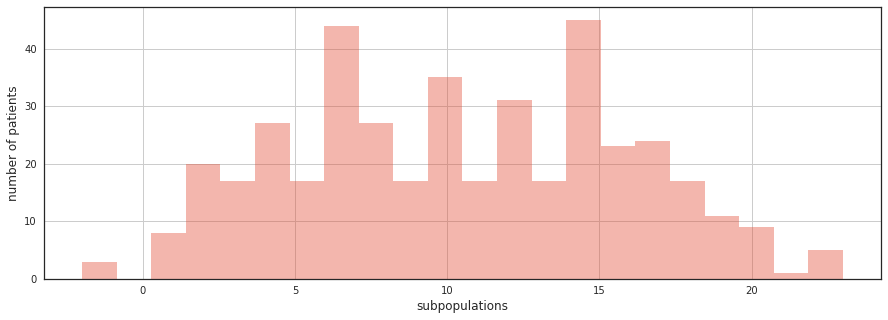

In [190]:
with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    fig = plt.figure(facecolor='w', figsize=(15,5))
    ax = fig.add_subplot(111)
    sns.distplot(df[1], bins=22, kde=False)
    ax.set_xlabel('subpopulations')
    ax.set_ylabel('number of patients')
    
of = '/projects/trans_scratch/validations/workspace/szong/EXPANDS_500/subpopulations.png'
plt.savefig(of, dpi=200)